## 1️⃣ Configuración Inicial

In [1]:
# Ensure required DataFrames are available in CI mode (fallback to pickles)
from pathlib import Path
import pandas as pd
from src.notebook_fixtures import normalize_umbral_dataframe

if "df_umbral" not in globals():
    p = Path.cwd() / "outputs" / "pickle_cache" / "df_umbral_limpio.pkl"
    if p.exists():
        df_umbral = normalize_umbral_dataframe(pd.read_pickle(p))
        globals()["df_umbral"] = df_umbral

ModuleNotFoundError: No module named 'src'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Configuración visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10
pd.set_option("display.max_columns", None)

print("✅ Configuración completada")

✅ Configuración completada


In [ ]:
import os
from pathlib import Path

if os.getenv("CI_TEST") == "true":
    sqlite_path = os.getenv("TEST_DB_PATH")
    if sqlite_path:
        from sqlalchemy import create_engine

        engine = create_engine(f"sqlite:///{sqlite_path}")
    from src.notebook_fixtures import load_pickles_to_namespace

    ns = load_pickles_to_namespace(Path.cwd() / "outputs" / "pickle_cache")
    for k, v in ns.items():
        globals()[k] = v

## 2️⃣ Conexión y Carga de Datos

In [ ]:
from sqlalchemy import create_engine
import urllib.parse
from utils.config import DB_CONNECTION_STRING

# Only create engine if not provided (CI test mode may inject a sqlite engine in advance)
if "engine" not in globals():
    quoted_conn_str = urllib.parse.quote_plus(DB_CONNECTION_STRING)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")

# Cargar tablas necesarias - YA VIENEN NORMALIZADAS DESDE SQL
df_ipc_nacional = pd.read_sql("SELECT * FROM INE_IPC_Nacional", engine)
df_umbral = pd.read_sql("SELECT * FROM INE_Umbral_Pobreza_Hogar", engine)
df_arope_edad = pd.read_sql("SELECT * FROM INE_AROPE_Edad_Sexo", engine)
df_gini_ccaa = pd.read_sql("SELECT * FROM INE_Gini_S80S20_CCAA", engine)
df_renta = pd.read_sql("SELECT * FROM INE_Renta_Media_Decil", engine)
df_carencia = pd.read_sql("SELECT * FROM INE_Carencia_Material_Decil", engine)

print("✅ Datos cargados (normalizados desde SQL)")

✅ Datos cargados correctamente


## 3️⃣ Análisis del Umbral de Pobreza: Nominal vs Real

### 3.1 Preparación de datos de inflación

In [ ]:
# Preparar datos de inflación
df_inflacion = (
    df_ipc_nacional[
        (df_ipc_nacional["Anio"] >= 2008) & (df_ipc_nacional["Anio"] <= 2023)
    ][["Anio", "Inflacion_Anual_%"]]
    .dropna(subset=["Anio"])
    .copy()
)

df_inflacion = df_inflacion.sort_values("Anio")

# Calcular deflactores (base 2008)
ano_base = 2008
anos_ordenados = sorted(df_inflacion["Anio"].unique())
idx_base = anos_ordenados.index(ano_base)
deflactor = {ano_base: 1.0}

for i in range(idx_base + 1, len(anos_ordenados)):
    ano_actual = anos_ordenados[i]
    ano_anterior = anos_ordenados[i - 1]
    inflacion = (
        df_inflacion[df_inflacion["Anio"] == ano_actual]["Inflacion_Anual_%"].values[0]
        / 100
    )
    deflactor[ano_actual] = deflactor[ano_anterior] * (1 + inflacion)

# Calcular inflación acumulada
df_inflacion["Inflacion_Acumulada"] = df_inflacion["Anio"].map(
    lambda x: ((deflactor.get(x, 1.0) - 1.0) * 100)
)

print(f"✅ Deflactores calculados para {len(deflactor)} años (base {ano_base} = 1.0)")

✅ Deflactores calculados para 16 años (base 2008 = 1.0)


### 3.2 Procesar umbral de pobreza y ajustar por inflación

In [ ]:
# Filtrar umbral para hogares de una persona
df_umbral_filtrado = df_umbral[
    df_umbral["Tipo_Hogar"] == "Hogares de una persona"
].copy()

df_umbral_prom = df_umbral_filtrado[["Anio", "Umbral_Euros"]].copy()
df_umbral_prom.columns = ["Anio", "Umbral_Promedio_€"]

# Procesar tasa AROPE
df_tasa_arope = (
    df_arope_edad[
        (df_arope_edad["Sexo"] == "Total")
        & (df_arope_edad["Edad"] == "Total")
        & (df_arope_edad["Indicador"] == "AROPE")
        & (df_arope_edad["Anio"].between(2008, 2023))
    ][["Anio", "Valor"]]
    .drop_duplicates()
    .sort_values("Anio")
)
df_tasa_arope.columns = ["Anio", "Tasa_AROPE_%"]

# Combinar y ajustar por inflación
df_analisis_conjunto = df_umbral_prom.merge(
    df_inflacion[["Anio", "Inflacion_Anual_%", "Inflacion_Acumulada"]],
    on="Anio",
    how="inner",
)
df_analisis_conjunto = df_analisis_conjunto.merge(df_tasa_arope, on="Anio", how="left")

# Aplicar deflactor
df_analisis_conjunto["Deflactor"] = df_analisis_conjunto["Anio"].map(deflactor)
df_analisis_conjunto["Umbral_Real_€_Base"] = (
    df_analisis_conjunto["Umbral_Promedio_€"] / df_analisis_conjunto["Deflactor"]
)
df_analisis_conjunto["Indice_Precios"] = df_analisis_conjunto["Deflactor"] * 100

print(f"✅ Análisis completo: {len(df_analisis_conjunto)} años procesados")

✅ Análisis completo: 16 años procesados


### 3.3 Comparación 2008 vs 2023: Crecimiento nominal vs real

In [ ]:
ano_final = 2023
indice_precios = {
    row["Anio"]: row["Indice_Precios"] for _, row in df_analisis_conjunto.iterrows()
}

# Extraer valores
umbral_nominal_inicial = df_analisis_conjunto[df_analisis_conjunto["Anio"] == ano_base][
    "Umbral_Promedio_€"
].values[0]
umbral_nominal_final = df_analisis_conjunto[df_analisis_conjunto["Anio"] == ano_final][
    "Umbral_Promedio_€"
].values[0]
umbral_real_inicial = df_analisis_conjunto[df_analisis_conjunto["Anio"] == ano_base][
    "Umbral_Real_€_Base"
].values[0]
umbral_real_final = df_analisis_conjunto[df_analisis_conjunto["Anio"] == ano_final][
    "Umbral_Real_€_Base"
].values[0]

crecimiento_nominal = (
    (umbral_nominal_final - umbral_nominal_inicial) / umbral_nominal_inicial
) * 100
crecimiento_real = (
    (umbral_real_final - umbral_real_inicial) / umbral_real_inicial
) * 100
inflacion_acumulada = ((indice_precios[ano_final] - 100) / 100) * 100

print("\n" + "=" * 100)
print("RESULTADOS: CRECIMIENTO REAL VS NOMINAL")
print("=" * 100)
print(f"\nPERÍODO: {ano_base} → {ano_final}")
print("\nUMBRAL NOMINAL:")
print(f"  • {ano_base}: €{umbral_nominal_inicial:,.0f}")
print(f"  • {ano_final}: €{umbral_nominal_final:,.0f}")
print(f"  • Crecimiento nominal: {crecimiento_nominal:+.2f}%")
print(f"\nINFLACIÓN ACUMULADA: {inflacion_acumulada:+.2f}%")
print(f"\nUMBRAL REAL (€{ano_base}):")
print(f"  • {ano_base}: €{umbral_real_inicial:,.0f}")
print(f"  • {ano_final}: €{umbral_real_final:,.0f}")
print(f"  • Crecimiento REAL: {crecimiento_real:+.2f}%")


RESULTADOS: CRECIMIENTO REAL VS NOMINAL

PERÍODO: 2008 → 2023

UMBRAL NOMINAL:
  • 2008: €8,379
  • 2023: €10,990
  • Crecimiento nominal: +31.16%

INFLACIÓN ACUMULADA: +29.90%

UMBRAL REAL (€2008):
  • 2008: €8,379
  • 2023: €8,461
  • Crecimiento REAL: +0.97%


### 3.4 Visualización: Umbral Nominal vs Real

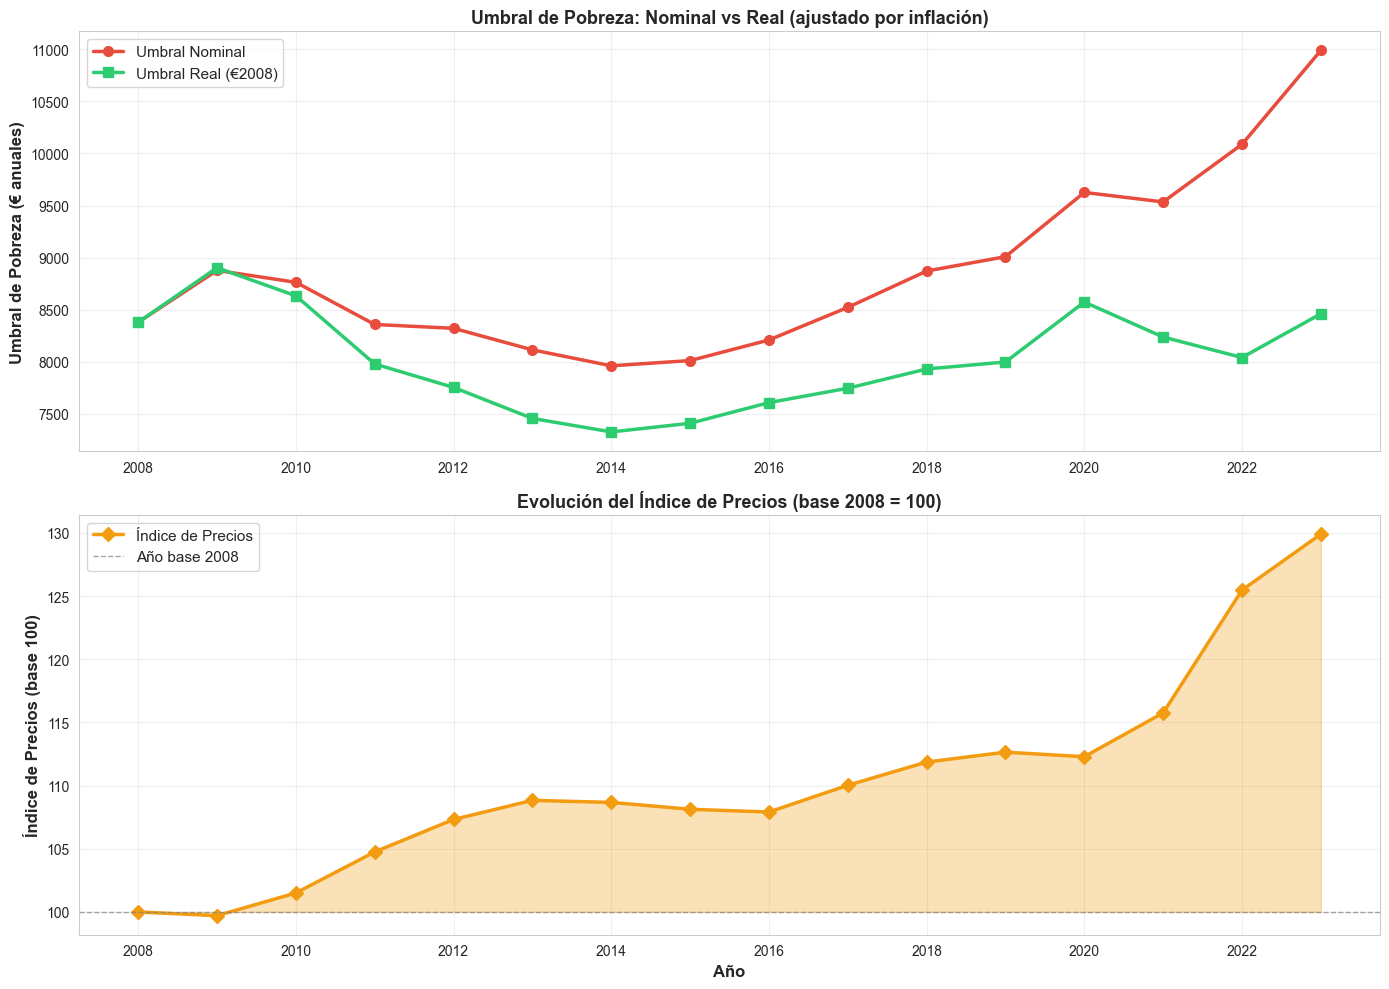

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Umbral Nominal vs Real
ax1 = axes[0]
ax1.plot(
    df_analisis_conjunto["Anio"],
    df_analisis_conjunto["Umbral_Promedio_€"],
    marker="o",
    color="#e74c3c",
    linewidth=2.5,
    markersize=7,
    label="Umbral Nominal",
)
ax1.plot(
    df_analisis_conjunto["Anio"],
    df_analisis_conjunto["Umbral_Real_€_Base"],
    marker="s",
    color="#2ecc71",
    linewidth=2.5,
    markersize=7,
    label=f"Umbral Real (€{ano_base})",
)
ax1.set_ylabel("Umbral de Pobreza (€ anuales)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Umbral de Pobreza: Nominal vs Real (ajustado por inflación)",
    fontsize=13,
    fontweight="bold",
)
ax1.legend(loc="best", fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Índice de Precios
ax2 = axes[1]
indices_anos = [
    df_analisis_conjunto[df_analisis_conjunto["Anio"] == a]["Indice_Precios"].values[0]
    for a in df_analisis_conjunto["Anio"]
]
ax2.plot(
    df_analisis_conjunto["Anio"],
    indices_anos,
    marker="D",
    color="#f39c12",
    linewidth=2.5,
    markersize=7,
    label="Índice de Precios",
)
ax2.fill_between(
    df_analisis_conjunto["Anio"], 100, indices_anos, alpha=0.3, color="#f39c12"
)
ax2.axhline(
    y=100,
    color="gray",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label=f"Año base {ano_base}",
)
ax2.set_xlabel("Año", fontsize=12, fontweight="bold")
ax2.set_ylabel("Índice de Precios (base 100)", fontsize=12, fontweight="bold")
ax2.set_title(
    f"Evolución del Índice de Precios (base {ano_base} = 100)",
    fontsize=13,
    fontweight="bold",
)
ax2.legend(loc="best", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4️⃣ Análisis de Desigualdad: Gini y S80/S20

In [ ]:
# Filtrar datos nacionales
df_gini_s80s20 = (
    df_gini_ccaa[df_gini_ccaa["Territorio"] == "Total Nacional"]
    .sort_values("Anio")[["Anio", "Gini", "S80/S20"]]
    .copy()
)
df_gini_s80s20.columns = ["Anio", "Gini", "S80S20"]

# Comparar 2008 vs 2023
gini_2008 = df_gini_s80s20[df_gini_s80s20["Anio"] == 2008]["Gini"].values[0]
gini_2023 = df_gini_s80s20[df_gini_s80s20["Anio"] == 2023]["Gini"].values[0]
s80s20_2008 = df_gini_s80s20[df_gini_s80s20["Anio"] == 2008]["S80S20"].values[0]
s80s20_2023 = df_gini_s80s20[df_gini_s80s20["Anio"] == 2023]["S80S20"].values[0]

cambio_gini = gini_2023 - gini_2008
cambio_gini_pct = (cambio_gini / gini_2008) * 100
cambio_s80s20 = s80s20_2023 - s80s20_2008
cambio_s80s20_pct = (cambio_s80s20 / s80s20_2008) * 100

print("\n" + "=" * 100)
print("INDICADORES DE DESIGUALDAD (2008-2023)")
print("=" * 100)
print("\n🔴 COEFICIENTE DE GINI")
print(f"  • 2008: {gini_2008:.4f}")
print(f"  • 2023: {gini_2023:.4f}")
print(f"  • Cambio: {cambio_gini:+.4f} ({cambio_gini_pct:+.1f}%)")
print(
    f"  • {'🟢 DISMINUYÓ desigualdad' if cambio_gini < 0 else '🔴 AUMENTÓ desigualdad'}"
)

print("\n💰 RATIO S80/S20")
print(f"  • 2008: {s80s20_2008:.2f}x")
print(f"  • 2023: {s80s20_2023:.2f}x")
print(f"  • Cambio: {cambio_s80s20:+.2f}x ({cambio_s80s20_pct:+.1f}%)")
print(f"  • {'🟢 DISMINUYÓ brecha' if cambio_s80s20 < 0 else '🔴 AUMENTÓ brecha'}")


INDICADORES DE DESIGUALDAD (2008-2023)

🔴 COEFICIENTE DE GINI
  • 2008: 32.4000
  • 2023: 31.5000
  • Cambio: -0.9000 (-2.8%)
  • 🟢 DISMINUYÓ desigualdad

💰 RATIO S80/S20
  • 2008: 5.60x
  • 2023: 5.50x
  • Cambio: -0.10x (-1.8%)
  • 🟢 DISMINUYÓ brecha


### 4.1 Visualización de Gini y S80/S20

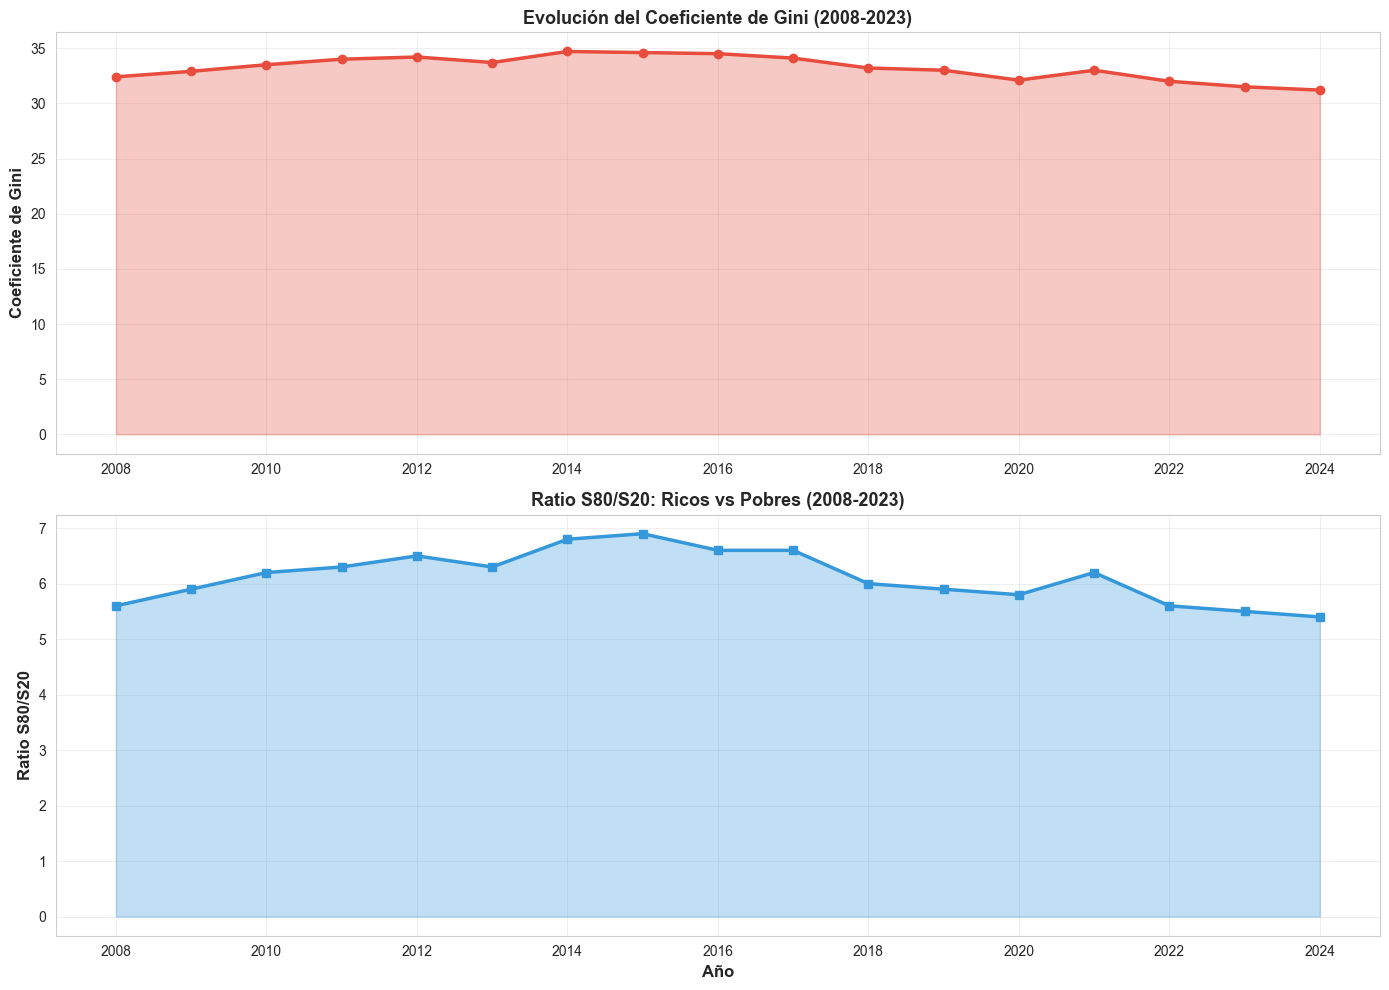

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Gini
ax1 = axes[0]
ax1.plot(
    df_gini_s80s20["Anio"],
    df_gini_s80s20["Gini"],
    marker="o",
    linewidth=2.5,
    color="#e74c3c",
)
ax1.fill_between(
    df_gini_s80s20["Anio"], df_gini_s80s20["Gini"], alpha=0.3, color="#e74c3c"
)
ax1.set_ylabel("Coeficiente de Gini", fontsize=12, fontweight="bold")
ax1.set_title(
    "Evolución del Coeficiente de Gini (2008-2023)", fontsize=13, fontweight="bold"
)
ax1.grid(True, alpha=0.3)

# Gráfico 2: S80/S20
ax2 = axes[1]
ax2.plot(
    df_gini_s80s20["Anio"],
    df_gini_s80s20["S80S20"],
    marker="s",
    linewidth=2.5,
    color="#3498db",
)
ax2.fill_between(
    df_gini_s80s20["Anio"], df_gini_s80s20["S80S20"], alpha=0.3, color="#3498db"
)
ax2.set_xlabel("Año", fontsize=12, fontweight="bold")
ax2.set_ylabel("Ratio S80/S20", fontsize=12, fontweight="bold")
ax2.set_title(
    "Ratio S80/S20: Ricos vs Pobres (2008-2023)", fontsize=13, fontweight="bold"
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ Análisis por Deciles: D1 vs D10

In [ ]:
# Preparar datos de renta por decil
df_renta_decil = df_renta[df_renta["Decil"].isin(["D1", "D10", "Total"])].copy()
df_renta_decil = df_renta_decil.rename(columns={"Media": "Renta_Media_Euros"})

# Merge con inflación
df_renta_ipc = df_renta_decil.merge(
    df_ipc_nacional[["Anio", "Inflacion_Anual_%"]], on="Anio", how="left"
).sort_values(["Anio", "Decil"])

# Calcular renta real
df_renta_ipc["Deflactor"] = df_renta_ipc["Anio"].map(deflactor)
df_renta_ipc["Renta_Real_€2008"] = (
    df_renta_ipc["Renta_Media_Euros"] / df_renta_ipc["Deflactor"]
)

print("✅ Deflactación de rentas completada")

✅ Deflactación de rentas completada


### 5.1 Comparación de crecimiento real D1 vs D10

In [ ]:
df_2008 = df_renta_ipc[df_renta_ipc["Anio"] == 2008].set_index("Decil")
df_2023 = df_renta_ipc[df_renta_ipc["Anio"] == 2023].set_index("Decil")

print("\n" + "=" * 100)
print("CRECIMIENTO REAL: Pobres (D1) vs Ricos (D10) - 2008 vs 2023")
print("=" * 100)

resultados = []
for decil in ["D1", "D10", "Total"]:
    if decil in df_2008.index and decil in df_2023.index:
        renta_2008_real = df_2008.loc[decil, "Renta_Real_€2008"]
        renta_2023_real = df_2023.loc[decil, "Renta_Real_€2008"]
        crecimiento_real = ((renta_2023_real - renta_2008_real) / renta_2008_real) * 100

        resultados.append(
            {
                "Decil": decil,
                "Renta 2008 (€2008)": f"{renta_2008_real:,.0f}",
                "Renta 2023 (€2008)": f"{renta_2023_real:,.0f}",
                "Crecimiento Real (%)": f"{crecimiento_real:+.2f}%",
                "Interpretación": "🟢 Mejoró" if crecimiento_real > 0 else "🔴 Empeoró",
            }
        )

df_crecimiento_tabla = pd.DataFrame(resultados)
print(df_crecimiento_tabla.to_string(index=False))


CRECIMIENTO REAL: Pobres (D1) vs Ricos (D10) - 2008 vs 2023
Decil Renta 2008 (€2008) Renta 2023 (€2008) Crecimiento Real (%) Interpretación
   D1              4,099              3,813               -6.98%      🔴 Empeoró
  D10             39,222             37,262               -5.00%      🔴 Empeoró
Total             16,190             15,917               -1.68%      🔴 Empeoró


### 5.2 Evolución del Ratio D10/D1

In [ ]:
df_pivot_deciles = df_renta_ipc.pivot_table(
    index="Anio", columns="Decil", values="Renta_Real_€2008"
)
df_pivot_deciles["Ratio_D10_D1"] = df_pivot_deciles["D10"] / df_pivot_deciles["D1"]

ratio_2008 = df_pivot_deciles.loc[2008, "Ratio_D10_D1"]
ratio_2023 = df_pivot_deciles.loc[2023, "Ratio_D10_D1"]
cambio_ratio = ratio_2023 - ratio_2008
cambio_ratio_pct = (cambio_ratio / ratio_2008) * 100

print("\n" + "=" * 100)
print("BRECHA: Ratio D10/D1")
print("=" * 100)
print(f"\n📊 2008: Los ricos ganaban {ratio_2008:.2f}x más que los pobres")
print(f"📊 2023: Los ricos ganan {ratio_2023:.2f}x más que los pobres")
print(
    f"\n{'🔴 AMPLIÓ brecha' if cambio_ratio > 0 else '🟢 REDUJO brecha'}: {cambio_ratio:+.2f}x ({cambio_ratio_pct:+.1f}%)"
)


BRECHA: Ratio D10/D1

📊 2008: Los ricos ganaban 9.57x más que los pobres
📊 2023: Los ricos ganan 9.77x más que los pobres

🔴 AMPLIÓ brecha: +0.20x (+2.1%)


### 5.3 Visualización de evolución por deciles

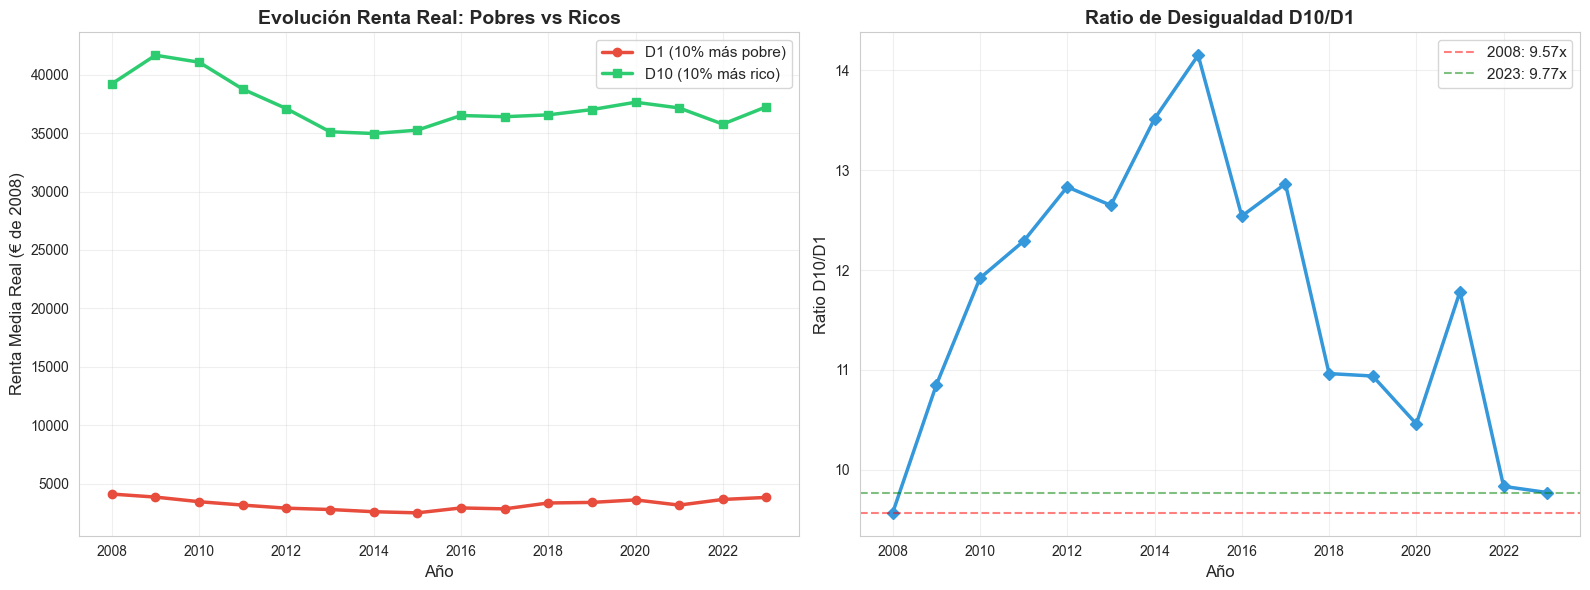

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Evolución Renta Real
ax1 = axes[0]
ax1.plot(
    df_pivot_deciles.index,
    df_pivot_deciles["D1"],
    marker="o",
    linewidth=2.5,
    label="D1 (10% más pobre)",
    color="#e74c3c",
)
ax1.plot(
    df_pivot_deciles.index,
    df_pivot_deciles["D10"],
    marker="s",
    linewidth=2.5,
    label="D10 (10% más rico)",
    color="#2ecc71",
)
ax1.set_title("Evolución Renta Real: Pobres vs Ricos", fontsize=14, fontweight="bold")
ax1.set_xlabel("Año", fontsize=12)
ax1.set_ylabel("Renta Media Real (€ de 2008)", fontsize=12)
ax1.legend(loc="best", fontsize=11)
ax1.grid(True, alpha=0.3)

# Panel 2: Ratio D10/D1
ax2 = axes[1]
ax2.plot(
    df_pivot_deciles.index,
    df_pivot_deciles["Ratio_D10_D1"],
    marker="D",
    linewidth=2.5,
    color="#3498db",
)
ax2.axhline(
    y=ratio_2008,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"2008: {ratio_2008:.2f}x",
)
ax2.axhline(
    y=ratio_2023,
    color="green",
    linestyle="--",
    alpha=0.5,
    label=f"2023: {ratio_2023:.2f}x",
)
ax2.set_title("Ratio de Desigualdad D10/D1", fontsize=14, fontweight="bold")
ax2.set_xlabel("Año", fontsize=12)
ax2.set_ylabel("Ratio D10/D1", fontsize=12)
ax2.legend(loc="best", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6️⃣ Análisis AROPE y Carencia Material

### 6.1 Evolución de AROPE (2008-2023)

In [ ]:
# Preparar datos AROPE
df_arope_anual = (
    df_arope_edad[
        (df_arope_edad["Sexo"] == "Total")
        & (df_arope_edad["Edad"] == "Total")
        & (df_arope_edad["Indicador"] == "AROPE")
    ]
    .groupby("Anio")["Valor"]
    .mean()
    .reset_index()
)
df_arope_anual.columns = ["Anio", "AROPE_%"]

# Comparar 2008 vs 2023
arope_2008 = df_arope_anual[df_arope_anual["Anio"] == 2008]["AROPE_%"].values[0]
arope_2023 = df_arope_anual[df_arope_anual["Anio"] == 2023]["AROPE_%"].values[0]
cambio_arope = arope_2023 - arope_2008
cambio_arope_pct = (cambio_arope / arope_2008) * 100

print("\n" + "=" * 100)
print("AROPE: Riesgo de Pobreza o Exclusión Social")
print("=" * 100)
print(f"\n  2008: {arope_2008:.1f}% de la población en riesgo")
print(f"  2023: {arope_2023:.1f}% de la población en riesgo")
print(f"  Cambio: {cambio_arope:+.1f} pp ({cambio_arope_pct:+.1f}%)")
print(
    f"\n  {'🔴 AUMENTÓ' if cambio_arope > 0 else '🟢 DISMINUYÓ'} el riesgo de exclusión social"
)


AROPE: Riesgo de Pobreza o Exclusión Social

  2008: 23.8% de la población en riesgo
  2023: 26.9% de la población en riesgo
  Cambio: +3.1 pp (+13.0%)

  🔴 AUMENTÓ el riesgo de exclusión social


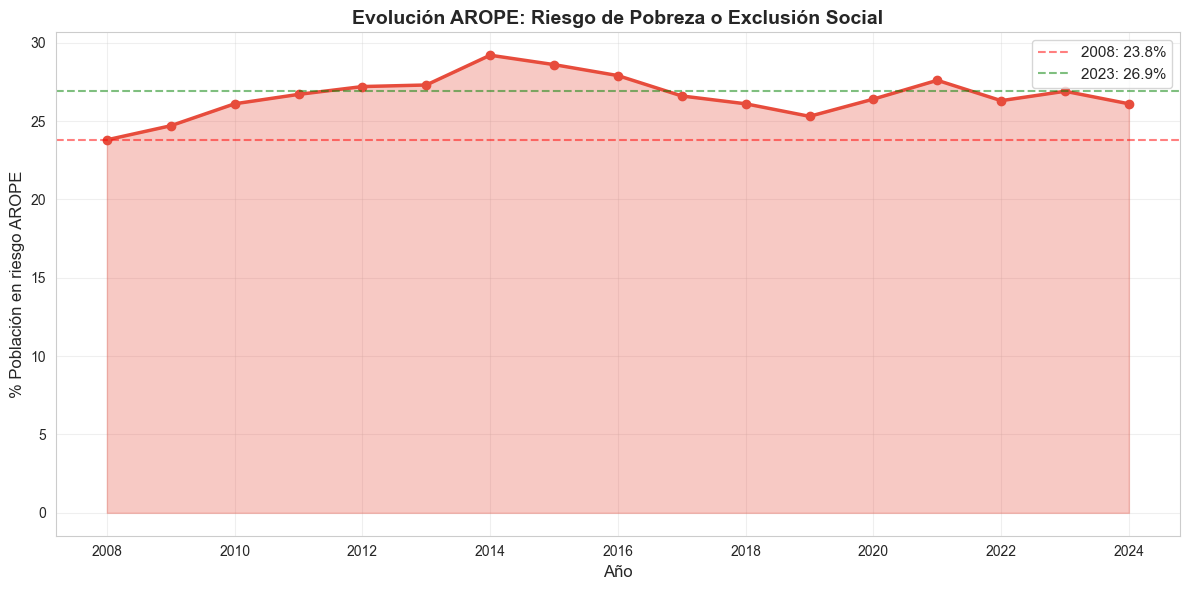

In [ ]:
# Visualización AROPE
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df_arope_anual["Anio"],
    df_arope_anual["AROPE_%"],
    marker="o",
    linewidth=2.5,
    color="#e74c3c",
)
ax.fill_between(
    df_arope_anual["Anio"], df_arope_anual["AROPE_%"], alpha=0.3, color="#e74c3c"
)
ax.axhline(
    y=arope_2008,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"2008: {arope_2008:.1f}%",
)
ax.axhline(
    y=arope_2023,
    color="green",
    linestyle="--",
    alpha=0.5,
    label=f"2023: {arope_2023:.1f}%",
)
ax.set_title(
    "Evolución AROPE: Riesgo de Pobreza o Exclusión Social",
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("% Población en riesgo AROPE", fontsize=12)
ax.legend(loc="best", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2 Carencia Material: D1 vs D10 (2023)

In [ ]:
# Procesar carencia material
df_carencia_2023 = (
    df_carencia[
        (df_carencia["Decil"].isin(["D1", "D10", "Total Nacional"]))
        & (df_carencia["Anio"] == 2023)
    ]
    .groupby("Decil")["Valor"]
    .mean()
    .reset_index()
)
df_carencia_2023.columns = ["Decil", "Carencia_Material_pct"]

carencia_d1 = df_carencia_2023[df_carencia_2023["Decil"] == "D1"][
    "Carencia_Material_pct"
].values[0]
carencia_d10 = df_carencia_2023[df_carencia_2023["Decil"] == "D10"][
    "Carencia_Material_pct"
].values[0]
ratio_carencia = carencia_d1 / carencia_d10

print("\n" + "=" * 100)
print("CARENCIA MATERIAL 2023: D1 vs D10")
print("=" * 100)
print(f"\n  D1 (pobres):  {carencia_d1:.1f}%")
print(f"  D10 (ricos):  {carencia_d10:.1f}%")
print(f"  Ratio:        {ratio_carencia:.1f}x más carencia en pobres")


CARENCIA MATERIAL 2023: D1 vs D10

  D1 (pobres):  36.7%
  D10 (ricos):  3.3%
  Ratio:        11.1x más carencia en pobres


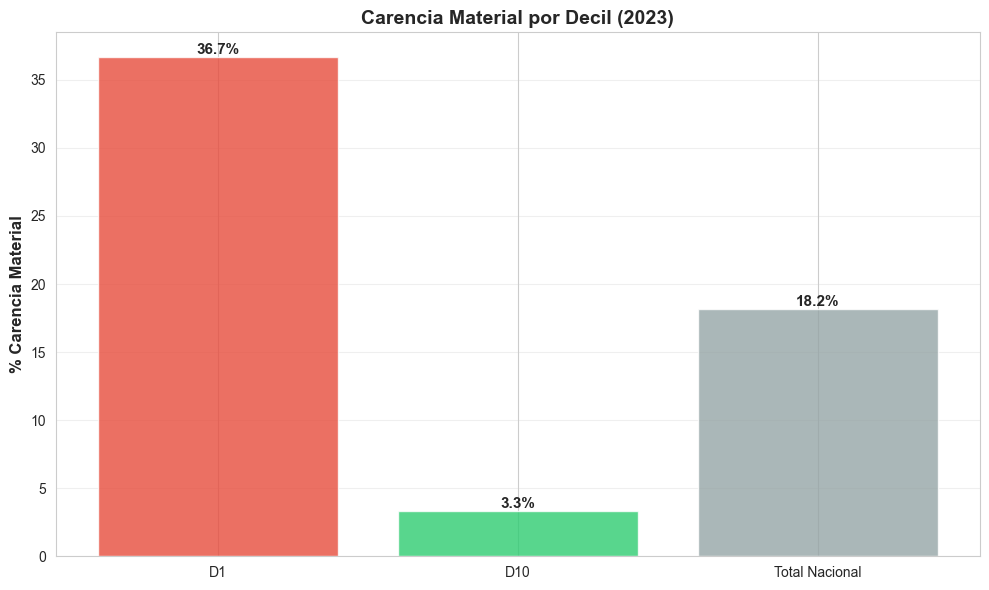

In [ ]:
# Visualización carencia material
fig, ax = plt.subplots(figsize=(10, 6))
colores = [
    "#e74c3c" if d == "D1" else "#2ecc71" if d == "D10" else "#95a5a6"
    for d in df_carencia_2023["Decil"]
]
bars = ax.bar(
    df_carencia_2023["Decil"],
    df_carencia_2023["Carencia_Material_pct"],
    color=colores,
    alpha=0.8,
)
ax.set_ylabel("% Carencia Material", fontsize=12, fontweight="bold")
ax.set_title("Carencia Material por Decil (2023)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## 7️⃣ Tabla Consolidada de Resultados

In [ ]:
tabla_consolidada = pd.DataFrame(
    {
        "Indicador": [
            "Gini (desigualdad relativa)",
            "S80/S20 (ricos vs pobres)",
            "Ratio D10/D1",
            "Renta D1 Real",
            "Renta D10 Real",
            "AROPE (riesgo exclusión)",
            "Carencia Material D1 vs D10",
        ],
        "2008": [
            f"{gini_2008:.4f}",
            f"{s80s20_2008:.2f}x",
            f"{ratio_2008:.2f}x",
            "Base",
            "Base",
            f"{arope_2008:.1f}%",
            "N/D",
        ],
        "2023": [
            f"{gini_2023:.4f}",
            f"{s80s20_2023:.2f}x",
            f"{ratio_2023:.2f}x",
            f'{((df_2023.loc["D1", "Renta_Real_€2008"] - df_2008.loc["D1", "Renta_Real_€2008"]) / df_2008.loc["D1", "Renta_Real_€2008"] * 100):+.2f}%',
            f'{((df_2023.loc["D10", "Renta_Real_€2008"] - df_2008.loc["D10", "Renta_Real_€2008"]) / df_2008.loc["D10", "Renta_Real_€2008"] * 100):+.2f}%',
            f"{arope_2023:.1f}%",
            f"{ratio_carencia:.1f}x",
        ],
        "Interpretación": [
            "🟢 Mejoró" if cambio_gini < 0 else "🔴 Empeoró",
            "🟢 Mejoró" if cambio_s80s20 < 0 else "🔴 Empeoró",
            "🔴 Empeoró" if cambio_ratio > 0 else "🟢 Mejoró",
            "🔴 Empeoró",
            "🔴 Empeoró",
            "🔴 Empeoró" if cambio_arope > 0 else "🟢 Mejoró",
            "🔴 Alta desigualdad",
        ],
    }
)

print("\n" + "=" * 150)
print("TABLA CONSOLIDADA: Todos los Indicadores (2008-2023)")
print("=" * 150)
print(tabla_consolidada.to_string(index=False))
print("=" * 150)


TABLA CONSOLIDADA: Todos los Indicadores (2008-2023)
                  Indicador    2008    2023     Interpretación
Gini (desigualdad relativa) 32.4000 31.5000           🟢 Mejoró
  S80/S20 (ricos vs pobres)   5.60x   5.50x           🟢 Mejoró
               Ratio D10/D1   9.57x   9.77x          🔴 Empeoró
              Renta D1 Real    Base  -6.98%          🔴 Empeoró
             Renta D10 Real    Base  -5.00%          🔴 Empeoró
   AROPE (riesgo exclusión)   23.8%   26.9%          🔴 Empeoró
Carencia Material D1 vs D10     N/D   11.1x 🔴 Alta desigualdad


## 8️⃣ Exportar Resultados

In [ ]:
# Guardar resultados principales
output_dir = project_root / "outputs"
output_dir.mkdir(exist_ok=True)

# Exportar tabla consolidada
tabla_consolidada.to_csv(
    output_dir / "indicadores_consolidados_2008_2023.csv", index=False
)

# Exportar series temporales
df_analisis_conjunto.to_parquet(
    output_dir / "umbral_pobreza_nominal_real.parquet", index=False
)
df_gini_s80s20.to_parquet(output_dir / "gini_s80s20_nacional.parquet", index=False)
df_pivot_deciles.to_parquet(output_dir / "renta_real_deciles.parquet")

print("\n✅ Resultados exportados a:", output_dir)
print("   • indicadores_consolidados_2008_2023.csv")
print("   • umbral_pobreza_nominal_real.parquet")
print("   • gini_s80s20_nacional.parquet")
print("   • renta_real_deciles.parquet")


✅ Resultados exportados a: c:\Users\mario\Desktop\Projects\desigualdad_social_etl\outputs
   • indicadores_consolidados_2008_2023.csv
   • umbral_pobreza_nominal_real.parquet
   • gini_s80s20_nacional.parquet
   • renta_real_deciles.parquet
